# Bird's-eye view on Image Anomaly Detection techniques: from shallow to large pretrained models 🦅🎯

## 0. Prelude


### Why Anomaly Detection

In the *taxonomy* of classical Computer Vision classification tasks, Anomaly Detection is certainly among the most challenging. In this particular setting a classification model is trained with *weak*-supervision, meaning that in general a representative set of samples for the "anomalous" class is not available during training (and technically even a definition of "anomaly" is missing), which makes the problem substantially ill-posed.

The rapid advancements of Machine Learning in recent years, thanks to the availability of data and computing power, have produced increasingly powerful techniques and models, unlocking exceptional results even in the case of the Anomaly Detection problem, and quickly saturating the benchmarks. However, as in many other cases in the field of Computer Vision, this by no means implies that the problem is solved in a general sense, and even the most effective techniques fall short when tested 'in the wild' (i.e., in real-world applications).


### What's in this notebook

This notebook presents some representative examples of Anomaly Detection approaches that have been relevant in the field of computer vision, along with demos on public datasets. Clearly, this work is not intended to be exhaustive, but rather aims to offer a bird's-eye view of the many possible approaches to the problem

It is organized in three sections: in the first one (🐤) two shallow-ML approaches are presented, and experiment are performed on the *MNIST* dataset; the second section (🐔) presents a deeper approach (based on a Conv-Autoencoder architecture) which has been very popular in recent years, using the *MVTec* Industrial Anomaly Detection dataset; the last section (🐲) presents a demonstration of a modern zero-shot classification approach, based on a Large Multimodal model, using the *Birds Species 525* Dataset.

The sections introduce approaches of increasing complexity, and the datasets were chosen to challenge the models power.

## 🐤. Shallow approaches: **Local Outlier Factor** and **One-Class SVM** (feat. MNIST)

In this section two examples of simple shallow-Machine Learning approaches are provided, using the plug-and-play implementations from the Scikit-Learn package.

The data used is from the well known MNIST classification Dataset, containing close-up images of handwritten digits. The Anomaly Detection task is defined as a binary classification of a single class ("normal") against all the others (e.g. digit "0/zero" vs all), with the model only having data from the normal class available during training (i.e. the standard AD setting, sometimes called One-Class Classification or Novelty Detection).

### *Local Outlier Factor* - **LOF**

A classic Machine Learning technique for Anomaly Detection is the so-called *Local Outlier Factor* - LOF, originally proposed in [Breunig et al. 2000](https://https://dl.acm.org/doi/10.1145/335191.335388) as a general approach for the One-Class classification problem, and not specifically designed for Image classification.

LOF assigns anomaly scores to each data point according to the deviation of its **local density** with respect to that of its neighbors. In particular, the algorithm is based on a k-nearest neighbors search, whose distances from the test data point are used to estimate its local density. Points with a significantly lower density with respect to neighbors are considered outliers.

The definition of Local Density (LrD) is hence a key element of this method, and it is in turn based on the idea of reachability-distance as follows:

&emsp; *(Given a points A, B)*

&emsp; &emsp; $\text{reachability-dist}_k(\text{A, B})=\text{max( k-dist(B), d(A,B) )}$

&emsp; &emsp; $\text{LrD}_k\text{ := mean}_{\text{B ∈ N}_k\text{(A)}}(\text{reachability-dist}_k(\text{A, B}))$

Where $\text{d(.,.)}$ is a generic distance function (e.g. Minkowski), $\text{k-dist(.)}$ is the distance of the k-th nearest neighbor of a data point, and $\text{N}_k\text{(.)}$ represents the set of its k-nearest neighbors

### *One-Class Support Vector Machine* - **OC-SVM**

One-Class SVM (Support Vector Machine) is another extremely popular algorithm for Anomaly Detection, introduced by [Schölkopf et al 2001](https://pubmed.ncbi.nlm.nih.gov/11440593/). It identifies outliers by learning a decision boundary (a hyperplane in the Schölkopf version, or a hypersphere, as proposed in later works) in the features space that optimally encloses the data points of the normal class, separating them from anomalies.

In particular, as in the standard SVM, the model's objective is to maximize the so-called margin between the data points of the two classes. A transformation into a higher-dimensional space is carried out using a kernel function, such as radial basis function (RBF), to make the data linearly separable (so called *kernel-trick*).



### Example of AD on MNIST Dataset

In [19]:
# import required packages
import random
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve

Let's start by defining some custom classes and functions useful for handling the MNIST dataset (custom Dataset class and plot function).

The MnistDataset object is simply a reorganization of the original MNIST dataset from the torchvision package, in which the training split only contains images from the class "0/zero" (standard AD setting). The original test set is split into a small split set and a new test set.

In [ ]:
# define a custom dataset class for easier MNIST loading and handling
# (main difference with the original torchvision Dataset object is the fact
# that the training split only contains class 0 items).

class MnistDataset(Dataset):
    def __init__(self, split="train"):
        split = split.lower()
        dataset = datasets.MNIST(root="data", train=(split=="train"), download=True)
        if split=="train":
            self.data = np.array(dataset.data[dataset.targets==0])
            self.labels = np.array(dataset.targets[dataset.targets==0])
        elif split=="val":
            self.data = np.array(dataset.data[:1000])
            self.labels = np.array(dataset.targets[:1000])
        else: # test split
            self.data = np.array(dataset.data[1000:])
            self.labels = np.array(dataset.targets[1000:])

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)

# plotting function for dataset examples
def plot_mnist_examples(dataset, N=10):
    fig, ax = plt.subplots(1, N, figsize=(N*1, 1), tight_layout=True)
    for i in range(N):
        ax[i].imshow(dataset.data[i], cmap="Greys")
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        txt = dataset.labels[i]
        ax[i].text(s=txt, x=1, y=1, verticalalignment="top", fontsize=10, color="red")

In [ ]:
%%capture
# instantiate datasets and plot some examples
train_mnist_ds = MnistDataset(split="train")
val_mnist_ds = MnistDataset(split="val")
test_mnist_ds = MnistDataset(split="test")

len train/val/test ds: 5923/1000/9000


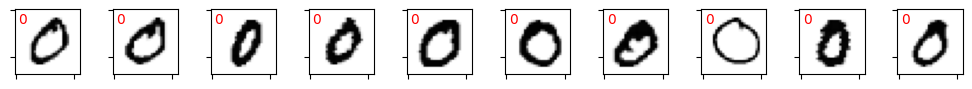

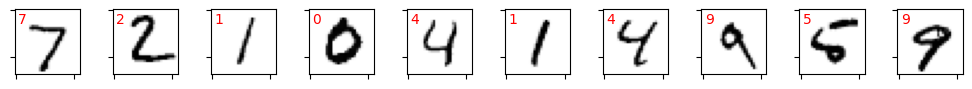

In [ ]:
print(f"len train/val/test ds: {len(train_mnist_ds)}/{len(val_mnist_ds)}/{len(test_mnist_ds)}")
plot_mnist_examples(train_mnist_ds)
plot_mnist_examples(val_mnist_ds)

Now we instantiate the LOF and OneClass-SVM classifiers. LOF requires the argument *novelty* to be set to True in the AD setting, while other parameters are left with their default values for the moment.

In [ ]:
# instantiate classifiers with default parameters
lof = LocalOutlierFactor(novelty=True)
OCsvm = OneClassSVM()

And then the classifiers are fit to the training data. Notice how images are simply flattened to 28*28 elements arrays in order to be fed to the algorithms: this is the easiest and most neutral choice, but certainly not the most effective (a more advanced approach would rather extract a lower dimensional representation of the data and use this for the classifiers).

In [ ]:
%%capture
# train classifiers
lof.fit(train_mnist_ds.data.reshape(-1, 28*28))
OCsvm.fit(train_mnist_ds.data.reshape(-1, 28*28))

Finally, we can evaluate the two algorithms on the test set and get classification accuracies in terms of area under the ROC curve (AUROC)

In [ ]:
# anomaly scores
scores_lof = lof.score_samples(test_mnist_ds.data.reshape(-1, 28*28))
scores_OCsvm = OCsvm.score_samples(test_mnist_ds.data.reshape(-1, 28*28))

# compute AUC scores
auc_lof = roc_auc_score((test_mnist_ds.labels==0), scores_lof)
auc_OCsvm = roc_auc_score((test_mnist_ds.labels==0), scores_OCsvm)

print(f"AUC lof: {auc_lof}")
print(f"AUC OCsvm: {auc_OCsvm}")

AUC lof: 0.9970975913206207
AUC OCsvm: 0.9833420986424685


A more informative way to report the classification results is to inspect the anomaly histograms (separately for the two classes) and the ROC curve plot

In [ ]:
# plotting functions for anomaly histograms and roc curves

def plot_anomaly_hist(scores, labels, ax, title=None, log=False, **kwargs):
    """
    Plot histograms of anomaly scores on an existing plt axis.
    """
    range = [np.min(scores), np.max(scores)]
    ax.hist(scores[labels == 0], color="tab:blue", alpha=0.5,
            label="Normal", density=True, range=range, **kwargs)
    ax.hist(scores[labels != 0], color="tab:orange", alpha=0.5,
            label="Anomaly", density=True, range=range, **kwargs)
    ax.set_xlabel("Anomaly Score (AU)")
    if title is not None:
        ax.set_title(title, fontsize=10)
    if log:
        ax.set_yscale("log")
    ax.legend()

def plot_roc_curve(fpr, tpr, ax, title=None, **kwargs):
    """
    Plot ROC curve on an existing plt axis.
    """
    ax.plot(fpr, tpr, label="ROC curve", **kwargs)
    ax.set_xlim([-0.05, 1.05]); ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    if title is not None:
        ax.set_title(title, fontsize=10)

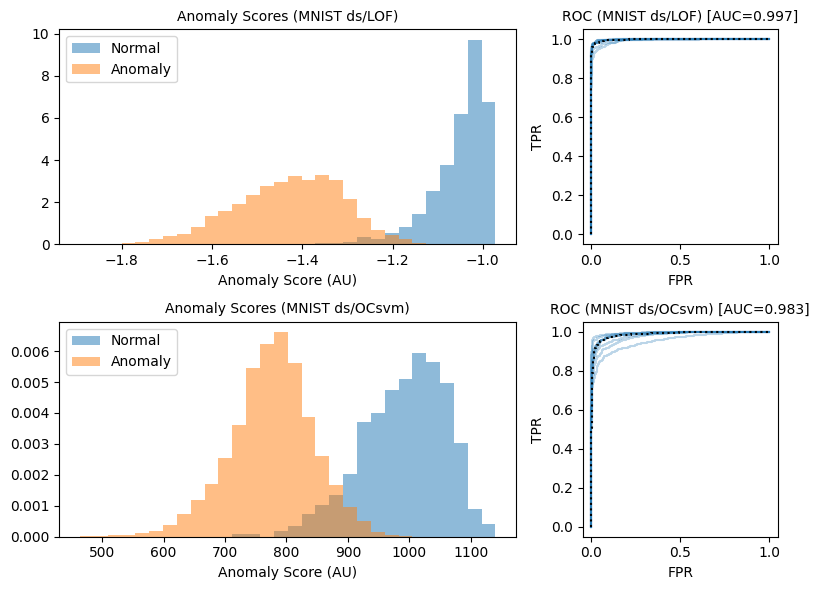

In [21]:
# anomaly histograms (zeros vs all classes)
fig = plt.figure(figsize=(8, 6), tight_layout=True)

plot_anomaly_hist(scores_lof, test_mnist_ds.labels, fig.add_subplot(2, 3, (1,2)),
                  title="Anomaly Scores (MNIST ds/LOF)", bins=30)
plot_anomaly_hist(scores_OCsvm, test_mnist_ds.labels, fig.add_subplot(2, 3, (4,5)),
                  title="Anomaly Scores (MNIST ds/OCsvm)", bins=30)

ax_roc = fig.add_subplot(2, 3, 3), fig.add_subplot(2, 3, 6)

# roc curves for zeros vs other single classes
for l in [1,2,3,4,5,6,7,8,9]:
    mask = np.logical_or(test_mnist_ds.labels==l, test_mnist_ds.labels==0)
    fpr_lof, tpr_lof, _ = roc_curve((test_mnist_ds.labels[mask]==0), scores_lof[mask])
    fpr_OCsvm, tpr_OCsvm, _ = roc_curve((test_mnist_ds.labels[mask]==0), scores_OCsvm[mask])

    plot_roc_curve(fpr_lof, tpr_lof, ax_roc[0], alpha=0.3, c="tab:blue")
    plot_roc_curve(fpr_OCsvm, tpr_OCsvm, ax_roc[1], alpha=0.3, c="tab:blue")

# roc curves for zeros vs all classes
plot_roc_curve(fpr_lof, tpr_lof, ax_roc[0], title=f"ROC (MNIST ds/LOF) [AUC={auc_lof:.3f}]",
               c="black", linestyle=":")
plot_roc_curve(fpr_OCsvm, tpr_OCsvm, ax_roc[1], title=f"ROC (MNIST ds/OCsvm) [AUC={auc_OCsvm:.3f}]",
               c="black", linestyle=":")

Now let's see if we can improve the accuracy of the classifiers by implementing a simple hyperparameters optimization strategy (manual grid search) using the previously defined validation split


In [23]:
from sklearn.model_selection import ParameterGrid

def grid_search(input_classifier, param_search, train_ds, val_ds, test_ds, verbose=True):
    """Hyperparameters optimization via grid search.
    param_search : dict ({"param1" : [values], "param2" : ... })
    datasets : [data_array, labels_array]
    """
    grid = ParameterGrid(param_search)
    best_auc = 0.
    best_params = None
    best_model = None
    for params in grid:
        print(f"params: {params}", end=" - ")
        classifier = input_classifier()
        classifier.set_params(**params)
        classifier.fit(train_ds.data.reshape(-1, 28*28))
        scores = classifier.score_samples(val_ds.data.reshape(-1, 28*28))
        auc = roc_auc_score((val_ds.labels==0), scores)
        print(f"AUC: {auc}", end="")
        if auc > best_auc:
            print(" *best*")
            best_model = classifier
            best_auc = auc
            best_params = params
        else:
            print("")
    return best_model, best_auc, best_params

param_search_lof = {"n_neighbors": [2**e for e in range(7)], # change 1 to 7
                    "p": [2],
                    "novelty" : [True]}
param_search_OCsvm = {"kernel": ["rbf", "linear"],
                      "nu": [0.0001, 0.001, 0.01, 0.1]}

print("Local Outlier Factor:")
best_lof, _, _ = grid_search(LocalOutlierFactor, param_search_lof, train_mnist_ds,
                             val_mnist_ds, test_mnist_ds)
print("\nOne Class SVM:")
best_OCsvm, _, best_params = grid_search(OneClassSVM, param_search_OCsvm, train_mnist_ds,
                                         val_mnist_ds, test_mnist_ds)

Local Outlier Factor:
params: {'n_neighbors': 1, 'novelty': True, 'p': 2} - AUC: 0.9643522982963677 *best*
params: {'n_neighbors': 2, 'novelty': True, 'p': 2} - AUC: 0.9905753776920604 *best*
params: {'n_neighbors': 4, 'novelty': True, 'p': 2} - AUC: 0.9952684024429443 *best*
params: {'n_neighbors': 8, 'novelty': True, 'p': 2} - AUC: 0.9979556412729026 *best*
params: {'n_neighbors': 16, 'novelty': True, 'p': 2} - AUC: 0.9979170684667309
params: {'n_neighbors': 32, 'novelty': True, 'p': 2} - AUC: 0.9978913532626165
params: {'n_neighbors': 64, 'novelty': True, 'p': 2} - AUC: 0.9979042108646738

One Class SVM:
params: {'kernel': 'rbf', 'nu': 0.0001} - AUC: 0.993339762134362 *best*
params: {'kernel': 'rbf', 'nu': 0.001} - AUC: 0.9933654773384764 *best*
params: {'kernel': 'rbf', 'nu': 0.01} - AUC: 0.9934554805528768 *best*
params: {'kernel': 'rbf', 'nu': 0.1} - AUC: 0.9871295403407264
params: {'kernel': 'linear', 'nu': 0.0001} - AUC: 0.8205335904853744
params: {'kernel': 'linear', 'nu': 0.0

OneClass-SVM improved on the validation set with *radial basis function* (rbf) kernel and a lower nu parameter. Let's evaluate it on test ds

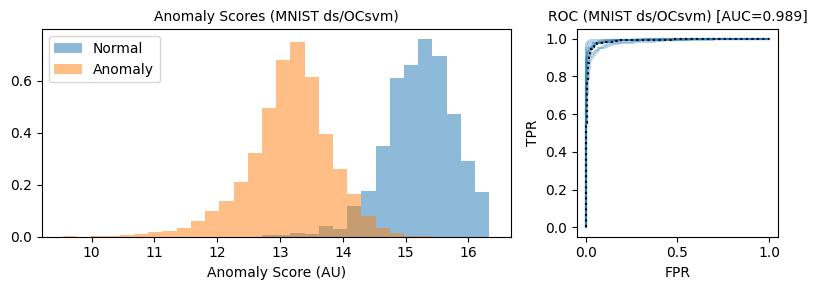

In [24]:
# best scores
scores_best_OCsvm = best_OCsvm.score_samples(test_mnist_ds.data.reshape(-1, 28*28))

# anomaly histograms (zeros vs all classes)
fig = plt.figure(figsize=(8, 3), tight_layout=True)

plot_anomaly_hist(scores_best_OCsvm, test_mnist_ds.labels, fig.add_subplot(1, 3, (1,2)),
                  title="Anomaly Scores (MNIST ds/OCsvm)", bins=30)

# roc curves for zeros vs other single classes
roc_ax = fig.add_subplot(1, 3, 3)
for l in [1,2,3,4,5,6,7,8,9]:
    mask = np.logical_or(test_mnist_ds.labels==l, test_mnist_ds.labels==0)
    auc_best_OCsvm = roc_auc_score((test_mnist_ds.labels[mask]==0), scores_best_OCsvm[mask])
    fpr_OCsvm, tpr_OCsvm, _ = roc_curve((test_mnist_ds.labels[mask]==0), scores_best_OCsvm[mask])

    plot_roc_curve(fpr_OCsvm, tpr_OCsvm, roc_ax, alpha=0.3, c="tab:blue")

# roc curves for zeros vs all classes
plot_roc_curve(fpr_OCsvm, tpr_OCsvm, roc_ax, title=f"ROC (MNIST ds/OCsvm) [AUC={auc_best_OCsvm:.3f}]",
               c="black", linestyle=":")


##  🐔. More complex architectures: **AEs-based methods** (feat. MVTec)

The Anomaly Detection task on the MNIST dataset (ove-vs-all setting) is a relatively simple task, and in the previous section it was shown how it can be solved with shallow ML approaches. When moving to higher dimensional datasets (e.g. higher resolution, color channels, and most importantly with more complex semantic content) more complex and deeper approaches are needed.

In this section we will use the MVTec Dataset ([MVTec-AD Dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad)), which is a well-established benchmark dataset for Industrial-Image Anomaly Detection. It provides high resolution color images from N different object classes, with different types of anomalies.

### AEs for Anomaly Detection

Convolutional Autoencoders and their variants have been shown to be extremely effective for Image Anomaly Detection and segmentation. The idea of "reconstruction-based Anomaly Detection" is to learn an encoding function to project an input to some latent space and a decoding function to project it back to the original input space. If the latent space is low-dimensional, it acts as an information bottleneck (compression) and the reconstruction will only be an approximate version of the input.

In the Anomaly Detection setting the two functions are optimized only on the inputs from the nominal class, and are expected to fail in correctly reconstructing any pattern not encountered during training (they're in some sense overfitted to the normal class).

In this section we will implement a very simple AE model (using the one from [MedIAnomaly code](https://github.com/caiyu6666/MedIAnomaly) as a main reference), and train it from scratch with SSIM (structural similarity metric) as in [Bergmann et al. 2018](https://arxiv.org/abs/1807.02011).

### Experiments on MVTec Dataset

In [26]:
%%capture
# load MVTec dataset to local memory (requires access to gdrive)
import time
from google.colab import drive

start = time.time()
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/birds_Anomaly_Detection/mvtec_anomaly_detection.tar.xz" "/content/data/mvtec.tar.xz"
!mkdir "/content/data/mvtec"
!tar -xf "/content/data/mvtec.tar.xz" -C "/content/data/mvtec"
!rm "/content/data/mvtec.tar.xz"
print(f"took {(time.time()-start):.2f}s")

First of all, let's define a custom Dataset class for the Anomaly Detection dataset (here a "prefetch" option can be used to load the entire dataset on the memory, to only access it once from the disk and speed up the training) and a function for visualization of images from the dataset

In [27]:
# define the MVTecDataset class
import os
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms import v2

class MVTecDataset(Dataset):
    def __init__(self, data_path, split, object_class, prefetch=False, resize=224, val_size=.2, rseed=42):
        """MVTec Dataset object.
        split : train/val/test
        object_class : bottle/cable/capsule/carpet/grid/hazelnut/leather/
                       metal_nut/pill/screw/tile/toothbrush/transistor/wood
        prefetch : if True the dataset will is prefetched in memory (faster getitem)
        val_size : amount of data used for validation
        """
        self.data_path = data_path
        self.split = split.lower()
        self.val_size = val_size
        self.object = object_class
        self.prefetch = prefetch
        self.resize = resize
        self.rseed = rseed

        # set_transforms
        if self.split == "train":
            self.transform = v2.Compose([v2.Resize(resize, Image.BILINEAR),
                                         v2.ToDtype(torch.float32, scale=True),
                                         v2.ColorJitter(brightness=0.15, contrast=0.15,
                                                        saturation=0., hue=0.),
                                         v2.RandomAdjustSharpness(sharpness_factor=0.5),
                                         v2.RandomHorizontalFlip(p=0.5), v2.RandomVerticalFlip(p=0.5),
                                         v2.RandomResizedCrop(resize, scale=(0.85, 1.0), ratio=(0.8, 1.2))])
        else:
            self.transform = v2.Compose([v2.Resize(resize, Image.BILINEAR),
                                         v2.ToDtype(torch.float32, scale=True)])

        # load imgs ans masks filenames and corresponding labels
        self.x, self.y, self.mask = self.load_dataset_folder()
        if self.prefetch:
            self.x, self.y, self.mask = self.prefetch_data()


    def prefetch_data(self):
        """Load data in memory for faster getitem.
        """
        x_pre, y_pre, mask_pre = [], [], []
        for i in range(len(self.x)):
            xi, yi, mask_i = self.x[i], self.y[i], self.mask[i]
            if yi == 0:
                mask_i = np.zeros([1, self.resize, self.resize])
            else:
                mask_i = Image.open(mask_i).convert("L")
            mask_i = tv_tensors.Mask(mask_i)
            yi = torch.tensor(yi, dtype=torch.long)
            xi = Image.open(xi).convert('RGB')
            xi = tv_tensors.Image(xi)
            xi, mask_i = self.transform(xi, mask_i)

            x_pre.append(xi)
            y_pre.append(yi)
            mask_pre.append(mask_i)
        return x_pre, y_pre, mask_pre

    def __getitem__(self, idx):
        if self.prefetch:
            return self.x[idx], self.y[idx], self.mask[idx]
        else:
            x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
            if y == 0:
                mask = np.zeros([1, self.resize, self.resize])
            else:
                mask = Image.open(mask).convert("L")
            mask = tv_tensors.Mask(mask)
            y = torch.tensor(y, dtype=torch.long)
            x = Image.open(x).convert('RGB')
            x = tv_tensors.Image(x)
            x, mask = self.transform(x, mask)
            return x, y, mask


    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        """This function loops over the subfolders and creates sorted lists
        of images, labels and masks, to be used for items retrieval.
        Default MVTec dirtree is assumed: /mvtec/objects/classes/imgs.
        """
        x, y, mask = [], [], []

        img_dir = os.path.join(self.data_path, self.object, "train" if self.split=="train" else "test")
        gt_dir = os.path.join(self.data_path, self.object, 'ground_truth')

        for cl in os.listdir(img_dir):
            # load images
            img_class_dir = os.path.join(img_dir, cl)
            img_fpath_list = sorted([os.path.join(img_class_dir, f) for f in os.listdir(img_class_dir)
                                     if (f.endswith('.png') or f.endswith('.jpg'))])
            x.extend(img_fpath_list)

            # load gt maps
            if cl == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_class_dir = os.path.join(gt_dir, cl)
                img_fname_list = [os.path.basename(fp)[:-4]+"_mask.png" for fp in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_class_dir, fn) for fn in img_fname_list]
                mask.extend(gt_fpath_list)
        x = np.array(x)
        y = np.array(y)
        mask = np.array(mask)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.split == "train":
            return list(x), list(y), list(mask)
        else:
            np.random.seed(self.rseed)
            p = np.random.permutation(len(x))
            nval = int(len(x)*self.val_size)

            if self.split == "val":
                return list(x[p[:nval]]), list(y[p[:nval]]), list(mask[p[:nval]])
            else:
                return list(x[p[nval:]]), list(y[p[nval:]]), list(mask[p[nval:]])

def custom_collate_fn(batch):
    x, y, mask = zip(*batch)
    x, mask = torch.stack(x, dim=0), torch.stack(mask, dim=0)
    y = torch.tensor(y)
    return x, y, mask

In [28]:
def plot_ds_examples(dataset, N=6, title=None):
    """Plot some examples of the dataset.
    """
    fig, ax = plt.subplots(1, N, figsize=(N*1.5, 1.5), tight_layout=True)
    for i in range(N):
        ax[i].imshow(dataset[i][0].numpy().transpose(1,2,0))
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
    ax[0].set_ylabel(title)

len train/val/test ds: 391/22/88


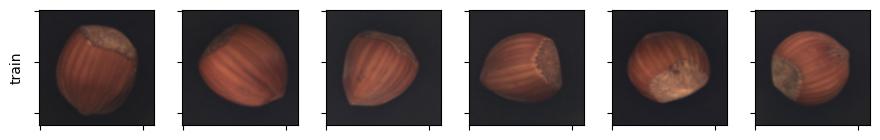

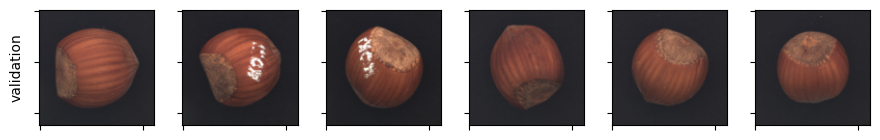

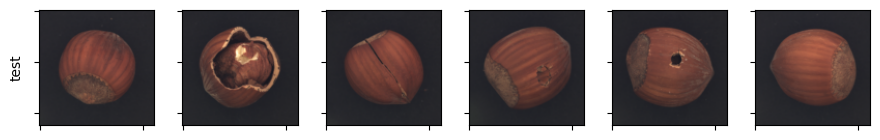

In [29]:
# instantiate datasets
train_mvtec_ds = MVTecDataset(data_path="/content/data/mvtec", split="train",
                              object_class="hazelnut", prefetch=True, resize=112)
test_mvtec_ds = MVTecDataset(data_path="/content/data/mvtec", split="test",
                             object_class="hazelnut", prefetch=True, resize=112)
val_mvtec_ds = MVTecDataset(data_path="/content/data/mvtec", split="val",
                           object_class="hazelnut", prefetch=True, resize=112)

print(f"len train/val/test ds: {len(train_mvtec_ds)}/{len(val_mvtec_ds)}/{len(test_mvtec_ds)}")
plot_ds_examples(train_mvtec_ds, title="train")
plot_ds_examples(val_mvtec_ds, title="validation")
plot_ds_examples(test_mvtec_ds, title="test")

And then we can define the building blocks of the AE model, the AE model itself and the functions necessary for its training

In [30]:
# definition of the building blocks for the convAE
import torch
import torch.nn as nn

class BasicConvBlock(nn.Module):
    """Basic block for the encoder"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
        super().__init__()
        self.last = last
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        if not self.last:
            x = self.batchnorm(x)
            x = self.relu(x)
        return x

class BasicConvTransposeBlock(nn.Module):
    """Basic block for the decoder"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, last=False):
        super().__init__()
        self.last = last
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=self.last)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        if not self.last:
            x = self.batchnorm(x)
            x = self.relu(x)
        return x

In [141]:
# definition of the convAE

class convAE(nn.Module):
    """Convolutional Autoencoder"""
    def __init__(self, in_channels, out_channels, latent_dim):
        super().__init__()
        self.conv_encoder = nn.Sequential(
            BasicConvBlock(in_channels, 64, 4, 2, 1),
            BasicConvBlock(64, 128, 4, 2, 1),
            BasicConvBlock(128, 256, 4, 2, 1),
            BasicConvBlock(256, 512, 4, 2, 1, last=True)
        )
        self.fc_bottleneck = nn.Sequential(
            BasicConvBlock(512, latent_dim, 1, 1, 0),
            BasicConvBlock(latent_dim, 512, 1, 1, 0)
        )
        self.conv_decoder = nn.Sequential(
            BasicConvTransposeBlock(512, 256, kernel_size=4, stride=2, padding=1),
            BasicConvTransposeBlock(256, 128, 4, 2, 1, 0),
            BasicConvTransposeBlock(128, 64, 4, 2, 1, 0),
            BasicConvTransposeBlock(64, out_channels, 4, 2, 1, 0, last=True)
        )

    def forward(self, x):
        x = self.conv_encoder(x)
        x = self.fc_bottleneck(x)
        x = self.conv_decoder(x)
        return x

convAE_model = convAE(in_channels=3, out_channels=3, latent_dim=8)

In [142]:
# define functions for training and evaluation steps

def train_step(model, optimizer, criterion, dataloader, device):
    """Train for one epoch.
    criterion : list of loss functions (tot loss = sum of losses)
    """
    loss_minibatch = []
    size_minibatch = []
    model.train()

    for idx_batch, (x, y, mask) in enumerate(dataloader):
        # forward pass
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        x_hat = model(x)
        # compute loss
        loss = sum([c(x_hat, x) for c in criterion])
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # store loss
        loss_minibatch.append(loss.item())
        size_minibatch.append(x.shape[0])

    loss_epoch = np.average(loss_minibatch, weights=size_minibatch)
    return loss_epoch


def eval_model(model, criterion, dataloader, device):
    """Evaluate the model
    criterion : list of loss functions (tot loss = sum of losses)
    """
    out = {"x":[], "x_hat":[], "y":[], "mask":[], "loss":[]}
    model.eval()

    with torch.no_grad():
        for idx_batch, (x, y, mask) in enumerate(dataloader):
            # forward pass
            x, y, mask = x.to(device), y.to(device), mask.to(device)
            x_hat = model(x)
            # compute loss
            loss = sum([c(x_hat, x) for c in criterion])
            # store loss
            out["x"].append(x)
            out["x_hat"].append(x_hat)
            out["y"].append(y)
            out["mask"].append(mask)
            out["loss"].append(loss)
    for k in out.keys():
        out[k] = torch.cat(out[k], dim=0).cpu()
    return out

In [143]:
%%capture
!pip install pytorch-msssim
from pytorch_msssim import ssim # structural similarity metrics

Let's now start the training, using a reconstruction loss:

&emsp; &emsp; $\text{RLoss(x,}\hat{x})= \text{SSIM}(x,\hat{x}) + \text{λ}*\text{MSE}(x,\hat{x})$

(given $x =$ input image; $\hat{x} =$ reconstruction; $λ =$ weight parameter)

In [144]:
# training loop

n_epochs = 160
optimizer = torch.optim.Adam(convAE_model.parameters(), lr=0.0008)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.5)
criterion = [(lambda x, x_hat: 1 - ssim(x_hat, x, data_range=1., size_average=True, win_size=11)),
             (lambda x, x_hat: 0.5*nn.MSELoss(reduction="mean")(x_hat, x))]
criterion_eval = [nn.MSELoss(reduction="none")]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convAE_model.to(device)
print(f"Running on device: {device}")

train_mvtec_loader = DataLoader(train_mvtec_ds, batch_size=32, shuffle=True,
                          num_workers=2, collate_fn=custom_collate_fn)
val_mvtec_loader = DataLoader(val_mvtec_ds, batch_size=16, shuffle=False,
                        num_workers=1, collate_fn=custom_collate_fn)
test_mvtec_loader = DataLoader(test_mvtec_ds, batch_size=16, shuffle=False,
                         num_workers=1, collate_fn=custom_collate_fn)

train_losses = []
val_losses_class0 = []
val_losses_class1 = []
aucs = []
for e in range(n_epochs):
    # train step
    train_loss = train_step(convAE_model, optimizer, criterion, train_mvtec_loader, device)

    # eval step
    out = eval_model(convAE_model, criterion_eval, val_mvtec_loader, device)
    loss_class0 = np.mean(out["loss"][out["y"]==0].numpy())
    loss_class1 = np.mean(out["loss"][out["y"]==1].numpy())
    anomaly_scores = np.max(out["loss"].numpy(), axis=(1,2,3)) # anomaly score = peak of reconstruction loss
    auc = roc_auc_score(out["y"].numpy(), anomaly_scores)

    train_losses.append(train_loss)
    val_losses_class0.append(loss_class0)
    val_losses_class1.append(loss_class1)
    aucs.append(auc)

    lr = optimizer.param_groups[0]["lr"]
    lr_scheduler.step()
    if (e+1)%20==0:
        print(f"Epoch {e+1}/{n_epochs}", end=" | ")
        print(f"train loss: {train_loss:.5f} | val loss (normal/anomalous): {loss_class0:.5f}/{loss_class1:.5f} | AUROC: {auc:.4f} | lr: {lr:.6f}")

Running on device: cuda
Epoch 20/160 | train loss: 0.16728 | val loss (normal/anomalous): 0.00221/0.00381 | AUROC: 0.8417 | lr: 0.000800
Epoch 40/160 | train loss: 0.13608 | val loss (normal/anomalous): 0.00151/0.00563 | AUROC: 0.8917 | lr: 0.000800
Epoch 60/160 | train loss: 0.09963 | val loss (normal/anomalous): 0.00071/0.00211 | AUROC: 0.9667 | lr: 0.000800
Epoch 80/160 | train loss: 0.09384 | val loss (normal/anomalous): 0.00068/0.00233 | AUROC: 0.9583 | lr: 0.000800
Epoch 100/160 | train loss: 0.08801 | val loss (normal/anomalous): 0.00059/0.00174 | AUROC: 0.9667 | lr: 0.000400
Epoch 120/160 | train loss: 0.08254 | val loss (normal/anomalous): 0.00054/0.00176 | AUROC: 0.9750 | lr: 0.000400
Epoch 140/160 | train loss: 0.07704 | val loss (normal/anomalous): 0.00053/0.00185 | AUROC: 0.9667 | lr: 0.000400
Epoch 160/160 | train loss: 0.07206 | val loss (normal/anomalous): 0.00047/0.00176 | AUROC: 0.9750 | lr: 0.000400


And finally let's evaluate on test set and plot results

(NB: in AD settings a validation split is usually not available at training time. In this example a small portion of test data was used as a validation split for demonstrating the effectiveness of the training, but it is not used for model selection)

In [145]:
# eval model on test set
out = eval_model(convAE_model, criterion_eval, test_mvtec_loader, device)
# compute anomaly scores and AUROC
scores = np.max(out["loss"].numpy(), axis=(1,2,3))
fpr, tpr, _ = roc_curve(out["y"].numpy(), scores)
auc = roc_auc_score(out["y"].numpy(), scores)
print(f"AUROC: {auc:.4f}")

AUROC: 0.9575


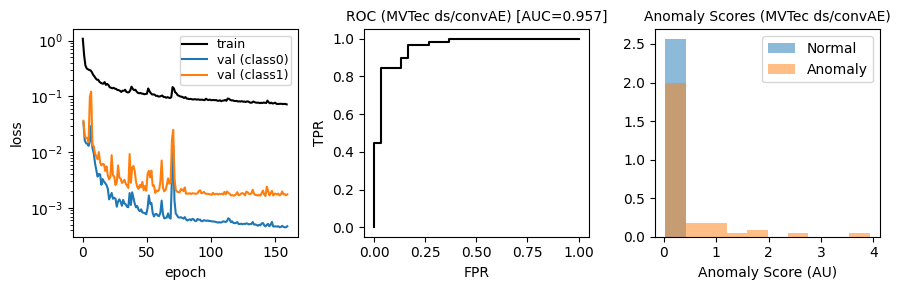

In [146]:
# plot training losses
fig = plt.figure(figsize=(9, 3), tight_layout=True)
ax0 = fig.add_subplot(1, 3, 1)
ax0.plot(np.arange(len(train_losses)), train_losses, label="train", color="black")
ax0.plot(np.arange(len(val_losses_class0))+0.5,val_losses_class0, label="val (class0)", color="tab:blue")
ax0.plot(np.arange(len(val_losses_class1))+0.5,val_losses_class1, label="val (class1)", color="tab:orange")
ax0.set_yscale("log")
ax0.set_xlabel("epoch"); ax0.set_ylabel("loss"); ax0.legend()
ax0.legend(labelspacing=0.2, borderpad=0.2, fontsize=9)

# ROC curve
ax1 = fig.add_subplot(1, 3, 2)
plot_roc_curve(fpr, tpr, ax1, title=f"ROC (MVTec ds/convAE) [AUC={auc:.3f}]", c="black")

# anomaly histograms
ax2 = fig.add_subplot(1, 3, 3)
plot_anomaly_hist(scores, out["y"].numpy(), ax2,
                  title="Anomaly Scores (MVTec ds/convAE)", bins=10)

An extremely convenient characteristics of the reconstruction based methods is that they naturally bring along a segmentation model as well, *for free*. The reconstruction error is infact evaluated at a local level (pixel level), and can represents itself a 2D estimated anomaly map.

In the images below are reported some example of input and reconstructed images, ground truth masks and reconstruction error maps (i.e. anomaly maps). These maps make the model's output interpretable and enable anomaly segmentation.

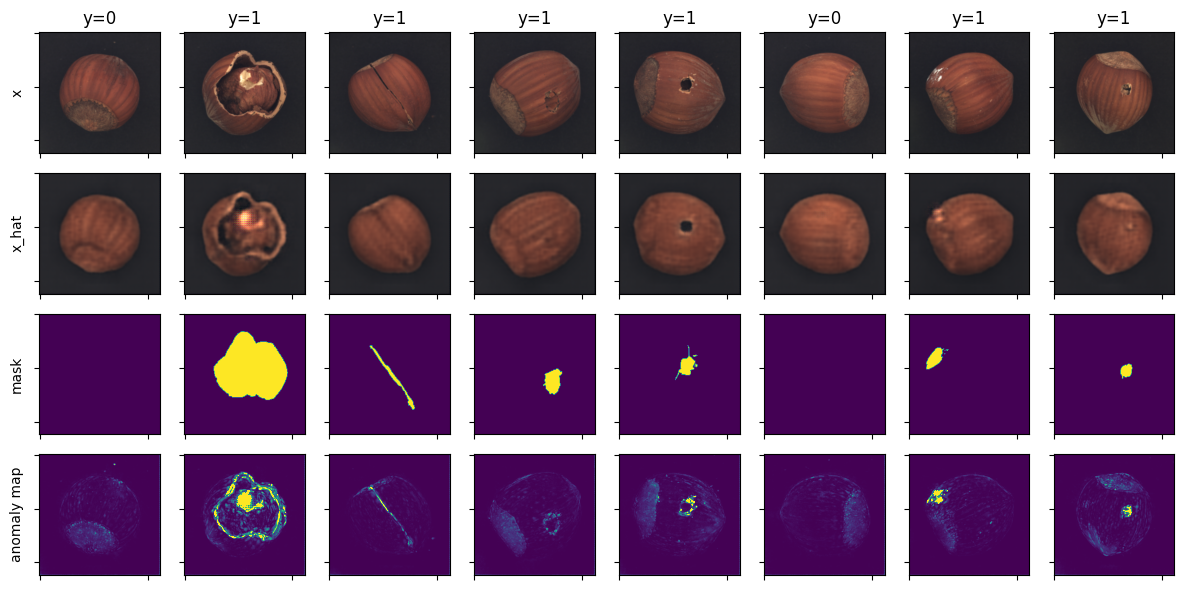

In [147]:
def plot_output_examples(out, N=8):
    fig, ax = plt.subplots(4, N, figsize=(N*1.5, 4*1.5), tight_layout=True)
    for i in range(N):
        x = out["x"][i].numpy().transpose(1,2,0)
        x_hat = out["x_hat"][i].detach().numpy().transpose(1,2,0)
        mask = out["mask"][i].numpy().transpose(1,2,0)
        loss = np.mean(out["loss"][i].detach().numpy(), axis=0)

        ax[0, i].set_title(f"y={out['y'][i].item()}")
        ax[0, i].imshow(x)
        ax[1, i].imshow(np.clip(x_hat, 0., 1.))
        ax[2, i].imshow(mask)
        ax[3, i].imshow(loss, vmin=0., vmax=0.02)
        for j in range(4):
            ax[j, i].set_xticklabels([])
            ax[j, i].set_yticklabels([])
    ax[0, 0].set_ylabel("x")
    ax[1, 0].set_ylabel("x_hat")
    ax[2, 0].set_ylabel("mask")
    ax[3, 0].set_ylabel("anomaly map")

plot_output_examples(out)

## 🐲. The very expensive ones: **Large-pretrained Transformers** (feat. Birds525)

In recent years, there have been significant advancements in the AD field, and many researchers shift their focus from the traditional setting to more advanced and complex tasks. Two notable examples are the so called few-shot/ and zero-shot/ Anomaly Detection settings, where instead of using a large dataset of normal images during training, only few examples or none at all are available.


One way to tackle these tasks is by exploiting very large models having a pre-existing and transferable knowledge, extracted from vast amount of data, typically without extrernal supervision.

In this section we will use the Birds 525 Species dataset ([Birds525-Kaggle](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)) to demostrate the capabilities of a modern large pre-trained model.

### An example of Large Pretrained Multimodal model: CLIP

We will use a version of the popular CLIP model from OpenAI [Radford et al. 2021](https://arxiv.org/abs/2103.00020), available on Huggingface ([CLIP-HuggingFace](https://huggingface.co/docs/transformers/model_doc/clip)). CLIP is based on a trsnformer architecture, and is a so called Vision-Language Model, meaning that it takes as inputs both Images and Text prompts.

Essentially, the model is able to encode both images and textual inputs into a shared latent space, which, due to the extensive pretraining it underwent, turns out to be semantically meaningful and can be effectively exploited for many down-stream tasks (e.g. text-to-image retrival, image-captioning, ecc.).

In the next section we will show the effectiveness of this model for **zero-shot AD** (as proposed, for example, in [Jeong et al. 2023](https://openaccess.thecvf.com/content/CVPR2023/html/Jeong_WinCLIP_Zero-Few-Shot_Anomaly_Classification_and_Segmentation_CVPR_2023_paper.html)).

The idea is as follows:

*   For each image that we want to classify, we provide the model with the **image** itself, and **two simple textual prompts**: the first describing the normal class and the second one describing the anomalous class (if no information is available regarding the anomalous class, a very general prompt is used).
*   The latent embeddings of the query image and the normal/anomalous prompts are computed
*   The similarity between image embedding and each of the two prompts is computed (simply as matrix multiplication)
*   A softmax function is applied, to get the probabilities of the image belonging to each of the two classes







### Zero-shot AD on Birds Species 525 dataset

In [148]:
%%capture
start = time.time()
!cp "/content/drive/My Drive/Colab_Notebooks/progetto_AML/birds_Anomaly_Detection/birds_species_525.zip" "/content/data/birds_species_525.zip"
!mkdir "/content/data/birds"
!unzip -q -d "/content/data/birds" "/content/data/birds_species_525"
!rm "/content/data/birds_species_525.zip"
print(f"took {(time.time()-start):.2f}s")

First of all, let's define a custom Dataset class for the Birds525 Dataset. Since we don't need to use all 525 birds species, an argument is provided to restrict the list

In [149]:
class BirdsDataset(Dataset):
    """Birds species 525 custom dataset class from Kaggle: https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data.
    species : list of species names to be included. Use "all" for 525 species classes
    """
    def __init__(self, dataset_path, species=["DALMATIAN PELICAN", "MALLARD DUCK"], split="train", resize=224, transforms=None):
        self.dataset_path = dataset_path
        if species=="all": # use all the 525 available species
            self.species = os.listdir(os.path.join(self.dataset_path, split))
        else:
            self.species = species
        self.split = split.strip().lower()
        self.resize = resize
        if transforms is None:
            self.transform = v2.Resize((resize, resize))
        else:
            self.transform = transforms
        self.x_paths, self.y = self.load_dataset_folder()

    def __getitem__(self, idx):
        x_path, y = self.x_paths[idx], self.y[idx]
        x = Image.open(x_path).convert('RGB')
        x, y = tv_tensors.Image(x), torch.as_tensor(y)
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x_paths)

    def load_dataset_folder(self):
        x_paths, y = [], []

        # read imgs from subfolders

        for i, s in enumerate(self.species):
            folder = os.path.join(self.dataset_path, self.split, s)
            if not os.path.exists(folder):
                raise ValueError(f"folder {folder} does not exist")
            for file in os.listdir(folder):
                if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
                    x_paths.append(os.path.join(self.dataset_path, folder, file))
                    y.append(i)

        # shuffle the dataset
        zipped = list(zip(x_paths, y))
        random.shuffle(zipped)
        x_paths, y = zip(*zipped)

        return x_paths, y

In [156]:
# define a subset of species to be used and instantiate ds
selected_species = ["EMPEROR PENGUIN", "DALMATIAN PELICAN", "MALLARD DUCK", "CROW",
                    "TEAL DUCK", "KIWI", "RED HEADED DUCK", "MAGPIE GOOSE", "SNOW GOOSE"]
test_birds_ds = BirdsDataset(dataset_path="/content/data/birds",
                             species=selected_species,
                             split="train", resize=224)
test_birds_dl = DataLoader(test_birds_ds, batch_size=256, shuffle=False, num_workers=0)
print(f"len test_birds_ds/dl: {len(test_birds_ds)}/{len(test_birds_dl)}")

len test_birds_ds/dl: 1394/6


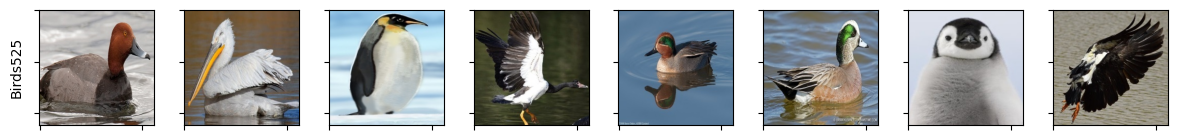

In [158]:
plot_ds_examples(test_birds_ds, title="Birds525", N=8)

Next, let's load the pretrained model from HuggingFace. For clarity, we will separately download the Vision and Text encoders, both of which are already equipped with the projector module to encode data in the shared latent space.

The *processor* and *tokenizer* modules are additional components needed to feed raw images and text prompts to the encoders.

Then, *extact_vembs* and *extract_tembs* functions are defined to improve readability of the code.

In [152]:
%%capture
# load vision-language pretrained model (CLIP)
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from transformers import AutoTokenizer, CLIPTextModel, CLIPTextModelWithProjection

CLIP_vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14")
CLIP_text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [153]:
# define a function for the extraction of vision embeddings

def extract_vembs(model, processor, dataloader, device, do_rescale=False):
    """Extraction of vision embeddings from items in a dataloader.
    Returns: list of vembs and corresponding labels.
    """
    print(f"Extracting vembs ({len(dataloader)} batches)...", end=" ")
    model.to(device)
    model.eval()

    vembs_list, labels_list = [], []
    for i, x in enumerate(dataloader):
        assert do_rescale == (x[0].max() > 1.), "Rescaling [0., 1.] range images"
        if len(x[0].shape)==3: # missing channels dimension = greyscale img
            x[0] = torch.stack([x[0],x[0],x[0]], dim=1)
        inputs = processor(images=x[0], return_tensors="pt", do_rescale=do_rescale, do_resize=224)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            # forward pass
            CLIPvembs = model(**inputs).image_embeds
        vembs_list.append(CLIPvembs.detach().cpu())
        labels_list.append(x[1])
    vembs, labels = torch.cat(vembs_list), torch.cat(labels_list)

    print(f"output shape: {vembs.shape} {labels.shape}")
    return vembs, labels

In [154]:
# define a function for the extraction of text embeddings

def extract_tembs(model, tokenizer, prompts, device, avg=True):
    """Extraction of text embeddings from input prompts.
    prompts : should be a dict with keys being class names,
    values being lists of text prompts.
    avg : return average embedding per each class
    """
    print(f"Extracting tembs...", end=" ")
    model.to(device)
    model.eval()

    out = {}
    for k in prompts.keys():
        inputs = tokenizer(prompts[k], padding=True, return_tensors="pt").to(device)
        with torch.no_grad():
            imnet_embs = CLIP_text_model(**inputs).text_embeds
            out[k] = torch.mean(imnet_embs.cpu(), dim=0, keepdim=True) if avg else imnet_embs
    print(f"output:", end=" ")
    [print(f"{k}-{out[k].shape}", end=" ") for k in out.keys()]
    print("")
    return out

At this point we're ready to extract vision embeddings from input images, and text embeddings from two manually defined textual prompts that should be as much discriminative as possible.

By setting *n_idx*=2, we're choosing to take the *Mallard Duck* species as normal class, and we will use *a photo of a mallard duck* and *a photo of a bird* as contrastive textual prompts  

In [159]:
# extract vision and text embeddings
n_idx=2 # set index of normal class
CLIPvembs_birds, labels_birds = extract_vembs(CLIP_vision_model, processor,
                                              test_birds_dl, device, do_rescale=True)
birds_text_prompts = {
    "normal" : [f"a photo of a {selected_species[n_idx].lower()}"],
    "anomalous" : ["a photo of a bird"]
}
CLIPtembs_birds_avg = extract_tembs(CLIP_text_model, tokenizer, birds_text_prompts, device, avg=True)

Extracting vembs (6 batches)... output shape: torch.Size([1394, 768]) torch.Size([1394])
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 


Finally, let's define a softmax scoring function, and a PCA visualization function for code readability, and plot the results.

From the 2D PCA visualization of the vision embeddings in the latent space it is possible to see how meaningful and semantically rich is this space, with visible structures and clusters that correspond to different birds species.

In [160]:
# function for Anomaly Detection scoring
def softmax_scores(x, normal_point, anomalous_point):
    # compute similarity scores
    normality_scores = torch.mm(x, normal_point.T)
    anomaly_scores = torch.mm(x, anomalous_point.T)
    # stack vectors and compute softmax
    _stack = torch.cat([normality_scores, anomaly_scores], dim=1)
    soft_scores = torch.nn.functional.softmax(_stack, dim=1)

    return soft_scores[:, 1].detach().numpy()

softscores_birds = softmax_scores(CLIPvembs_birds, CLIPtembs_birds_avg["normal"], CLIPtembs_birds_avg["anomalous"])
print(f"softscores_birds shape: {softscores_birds.shape}")

softscores_birds shape: (1394,)


In [161]:
# define a function for 2D vembs PCA and visualization
from sklearn.decomposition import PCA

def plot_2Dpca(vembs, labels, ax, title=None, nominal_idx=0, **kwargs):
    """Perform 2D PCA on input data and plot on existing axis.
    """
    pca = PCA(n_components=2)
    vembs_pca = pca.fit_transform(vembs.numpy())
    ax.scatter(vembs_pca[:, 0][labels==nominal_idx], vembs_pca[:, 1][labels==nominal_idx],
               c="tab:blue", label="normal", **kwargs)
    ax.scatter(vembs_pca[:, 0][labels!=nominal_idx], vembs_pca[:, 1][labels!=nominal_idx],
               c="tab:orange", label="anomalous", **kwargs)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title(title)
    ax.legend(loc="upper left", labelspacing=0.2, borderpad=0.2)
    if title is not None: ax.set_title(title)

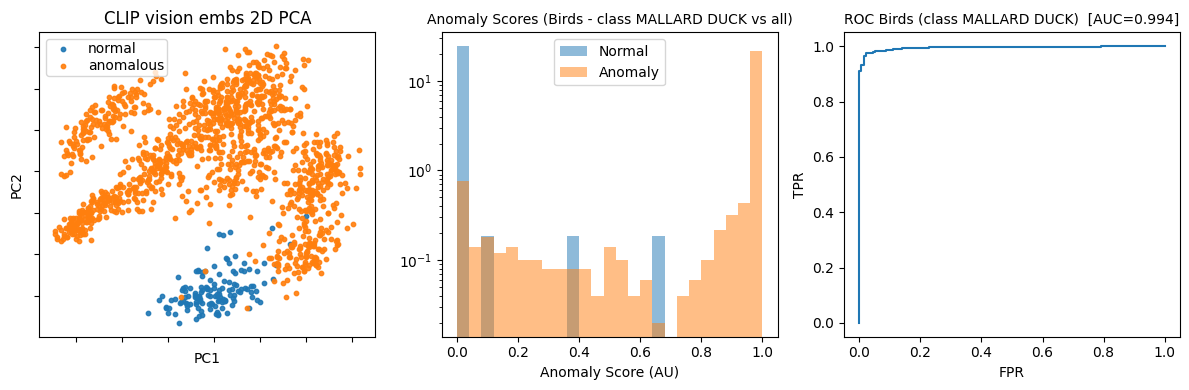

In [162]:
# testing the zero shot approach on Birds

# ROC
fpr, tpr, _ = roc_curve((labels_birds!=n_idx).numpy(), softscores_birds)
auc = roc_auc_score((labels_birds!=n_idx).numpy(), softscores_birds)
# plots
fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
plot_2Dpca(CLIPvembs_birds, labels_birds, ax[0], title="CLIP vision embs 2D PCA",
          nominal_idx=n_idx, marker="o", s=10, alpha=0.9)
plot_anomaly_hist(softscores_birds, labels_birds!=n_idx, ax[1], log=True,
                  title=f"Anomaly Scores (Birds - class {selected_species[n_idx]} vs all)", bins=25)
plot_roc_curve(fpr, tpr, ax[2], title=f"ROC Birds (class {selected_species[n_idx]})  [AUC={auc:.3f}]")

### Evaluating the zero-shot approach on MNIST dataset

For the sake of curiosity, it is interesting to observe how the CLIP-based zero-shot approach handles the AD task on the MNIST dataset.

Since CLIP is primarily trained on natural images, the results clearly indicate that the model suffers from the strong 'domain shift' in this case.

In [163]:
%%capture
# testing the zero shot approach on MNIST
# dataloader
test_mnist_ds = datasets.MNIST(root="/content/data/MNIST", train=False,
                               download=True, transform=transforms.ToTensor())
test_mnist_dl = DataLoader(val_mnist_ds, batch_size=128, shuffle=False,
                           num_workers=0)

Extracting vembs (8 batches)... output shape: torch.Size([1000, 768]) torch.Size([1000])
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 


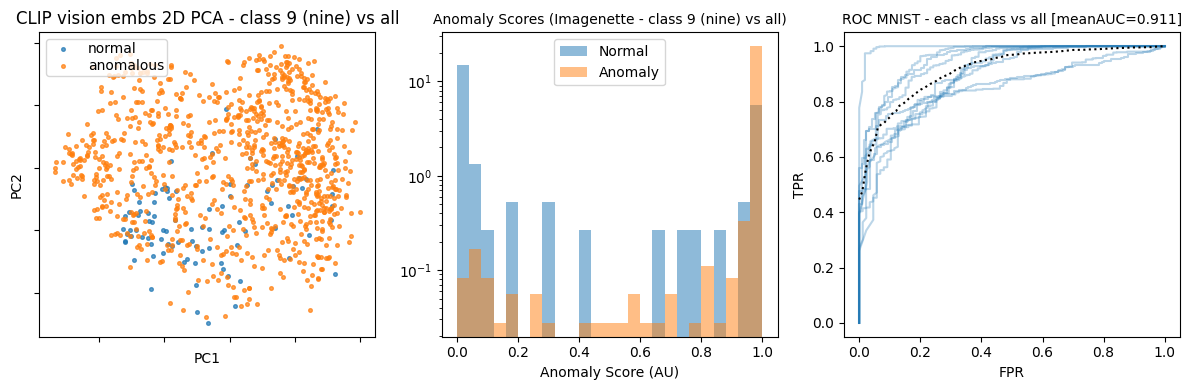

In [164]:
# extract vision and text embeddings
CLIPvembs_mnist, labels_mnist = extract_vembs(CLIP_vision_model, processor,
                                              test_mnist_dl, device, do_rescale=True)


fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
fpr_list, tpr_list = [], []
numbers = ["0 (zero)", "1 (one)", "2 (two)", "3 (three)", "4 (four)",
           "5 (five)", "6 (six)", "7 (seven)", "8 (eight)", "9 (nine)"]
for n_idx in range(10):
    # define text prompts
    mnist_text_prompts = {
        "normal" : [f"an image of the number {numbers[n_idx]}"],
        "anomalous" : ["an image of a number"]
    }
    CLIPtembs_mnist_avg = extract_tembs(CLIP_text_model, tokenizer, mnist_text_prompts, device, avg=True)

    # compute softscores
    softscores_mnist = softmax_scores(CLIPvembs_mnist, CLIPtembs_mnist_avg["normal"], CLIPtembs_mnist_avg["anomalous"])

    # compute zero-shot Anomaly Detection accuracy and plot
    # ROC
    fpr, tpr, _ = roc_curve((labels_mnist!=n_idx).numpy(), softscores_mnist)
    auc = roc_auc_score((labels_mnist!=n_idx).numpy(), softscores_mnist)
    # plots
    if n_idx==9:
        plot_2Dpca(CLIPvembs_mnist, labels_mnist, ax[0], title=f"CLIP vision embs 2D PCA - class {numbers[n_idx]} vs all",
                   nominal_idx=n_idx, marker="o", s=7, alpha=0.7)
        plot_anomaly_hist(softscores_mnist, labels_mnist!=n_idx, ax[1], log=True,
                         title=f"Anomaly Scores (Imagenette - class {numbers[n_idx]} vs all)", bins=25)
    plot_roc_curve(fpr, tpr, ax[2], title=None, c="tab:blue", alpha=0.3)
    tpr_list.append(np.interp(np.linspace(0., 1., 100), fpr, tpr))

# plot average ROC curve
tpr_avg = np.mean(tpr_list, axis=0)
plot_roc_curve(np.linspace(0, 1., 100), tpr_avg, ax[2], title=f"ROC MNIST - each class vs all [meanAUC={np.mean(tpr_avg):.3f}]", c="black", linestyle=":")

### Evaluating the zero-shot approach on MVTec dataset

It is also interesting to examine the results of zero-shot AD on the MVTec dataset.

In this case as well, the results are far from the exceptional performance observed with the Birds dataset, highlighting another limitation of this model: the vision encoder from CLIP is trained to produce representations that align with generic image captions, capturing the overall semantic content of the image while often overlooking small details (e.g., cracks on a hazelnut).

Extracting vembs (6 batches)... output shape: torch.Size([88, 768]) torch.Size([88])
Extracting tembs... output: normal-torch.Size([1, 768]) anomalous-torch.Size([1, 768]) 


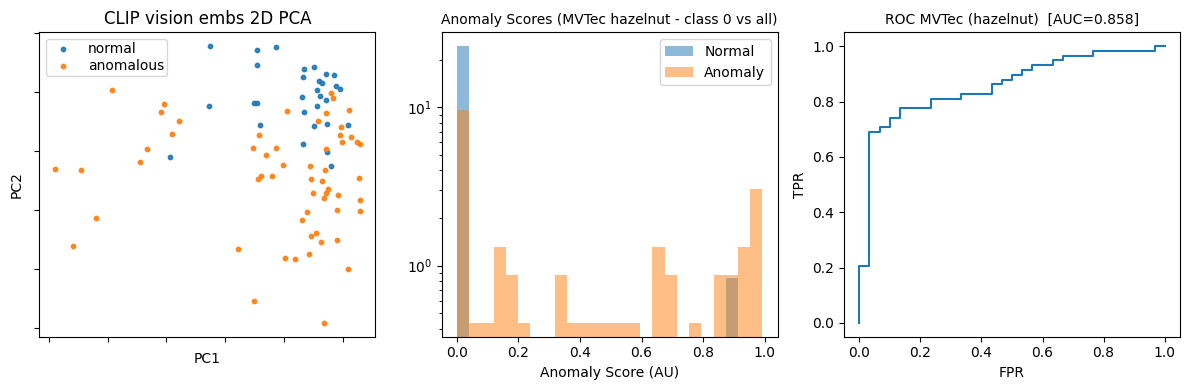

In [180]:
# testing the zero shot approach on MVTec

# dataloader
object = "hazelnut"
test_mvtec_ds = MVTecDataset(data_path="/content/data/mvtec", split="test",
                             object_class=object, prefetch=True, resize=224)
test_mvtec_dl = DataLoader(test_mvtec_ds, batch_size=16, shuffle=False, num_workers=0)

# extract vision and text embeddings
CLIPvembs_mvtec, labels_mvtec = extract_vembs(CLIP_vision_model, processor,
                                              test_mvtec_dl, device, do_rescale=False)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
# define text prompts
mvtec_text_prompts = {
    "normal" : [f"a photo of a {object}"],
    "anomalous" : [f"a photo of a anomalous (damaged, stained, broken ecc.) {object}"]
}
CLIPtembs_mvtec_avg = extract_tembs(CLIP_text_model, tokenizer, mvtec_text_prompts, device, avg=True)

# compute softscores
softscores_mvtec = softmax_scores(CLIPvembs_mvtec, CLIPtembs_mvtec_avg["normal"], CLIPtembs_mvtec_avg["anomalous"])

# compute zero-shot Anomaly Detection accuracy and plot
n_idx=0
# ROC
fpr, tpr, _ = roc_curve((labels_mvtec!=n_idx).numpy(), softscores_mvtec)
auc = roc_auc_score((labels_mvtec!=n_idx).numpy(), softscores_mvtec)
# plots
plot_2Dpca(CLIPvembs_mvtec, labels_mvtec, ax[0], title="CLIP vision embs 2D PCA",
          nominal_idx=n_idx, marker="o", s=10, alpha=0.9)
plot_anomaly_hist(softscores_mvtec, labels_mvtec!=n_idx, ax[1], log=True,
                  title=f"Anomaly Scores (MVTec {object} - class 0 vs all)", bins=25)
plot_roc_curve(fpr, tpr, ax[2], title=f"ROC MVTec ({object})  [AUC={auc:.3f}]")
